In [1]:
import gzip

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

# Preprocessing

## Meta data

In [2]:
def read_geo_series_matrix(file_path):
    cols = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sampleId = [i.strip('"') for i in line.split()[1:]]
                cols["sampleId"] = sampleId
            elif line.startswith("!Sample_characteristics_ch1"):
                _ = line[28:].strip().strip('"').split('"\t"')
                category = _[0].split(": ")[0].replace(" ", "_")
                values = [i.split(": ")[1] for i in _]
                cols.update({category: values})
    
    return pd.DataFrame(cols)

In [3]:
meta = read_geo_series_matrix("../rawData/GSE49711_series_matrix.txt.gz")
meta.index = meta.sampleId
meta.shape

(498, 11)

In [4]:
meta = meta.loc[meta.class_label.isin(["0", "1"])]
meta.shape

(272, 11)

In [5]:
pd.crosstab(meta.inss_stage, meta.class_label)

class_label,0,1
inss_stage,,
1,100,1
2,44,4
3,7,14
4,0,68
4S,30,4


In [6]:
pd.crosstab(meta.high_risk, meta.class_label)

class_label,0,1
high_risk,,
0,181,13
1,0,78


In [7]:
meta.Sex.replace({"M":1, "F":0}, inplace=True)
meta.replace({"N/A":np.nan}, inplace=True)

In [8]:
stage_dummy = pd.get_dummies(meta.inss_stage, prefix='inss_stage')
meta = pd.concat([meta, stage_dummy], axis=1)

In [9]:
meta.dropna(inplace=True)

In [10]:
meta = meta[["Sex", "age_at_diagnosis", "mycn_status", "high_risk", 
               "inss_stage_1", "inss_stage_2", "inss_stage_3", "inss_stage_4", "inss_stage_4S",
               "class_label"
              ]]

In [11]:
meta = meta.astype("double")

In [12]:
meta.head()

,Sex,age_at_diagnosis,mycn_status,high_risk,inss_stage_1,inss_stage_2,inss_stage_3,inss_stage_4,inss_stage_4S,class_label
sampleId,,,,,,,,,,
SEQC_NB001,1.0,987.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB002,1.0,1808.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB003,0.0,625.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB005,0.0,536.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB006,1.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Gene level

In [13]:
rna = pd.read_table("../rawData/GSE49711_SEQC_NB_TAV_G_log2.final.txt.gz")
rna = rna[~ rna.Gene.str.contains("[a-z]")]
rna.drop(["Gene_set","NCBI_gene_ID","RefSeq_transcript_ID","Chromosome","Strand","Start","End"], axis=1, inplace=True)
X = rna.iloc[:,1:].transpose()
X.columns = rna.Gene

In [14]:
X = X.loc[meta.index] # keep only samples with valid Ys

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, meta.class_label.astype("int"), test_size=0.3, random_state=1234)

# QC

<Axes: >

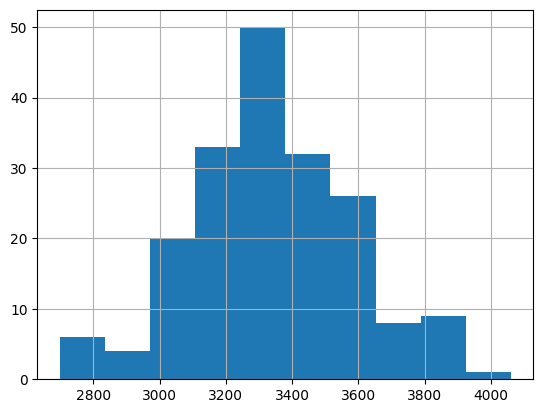

In [16]:
(X_train == 0).sum(axis=1).hist() # per-sample expression

<Axes: >

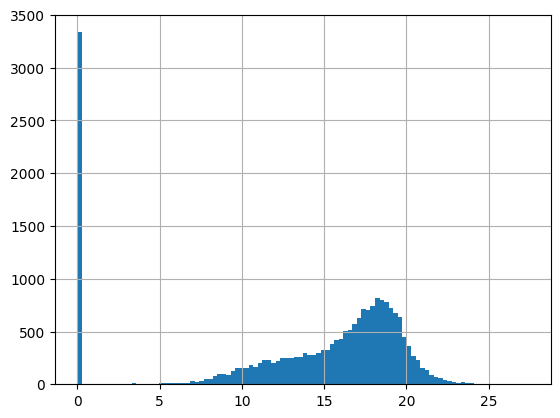

In [17]:
X_train.median().hist(bins=100)

In [18]:
X_train = X_train.loc[:, X_train.median() > 5]

In [19]:
X_train.shape

(189, 17706)

In [20]:
X_train

Gene,A1BGAS,A2BP1,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sampleId,,,,,,,,,,,,,,,,,,,,,
SEQC_NB096,16.1434,19.0748,15.2934,20.7683,11.5196,0.0000,14.7459,11.5679,19.8594,18.6028,...,18.9712,19.0694,14.8084,15.7586,18.6447,8.6691,19.1588,19.9347,19.0222,18.5647
SEQC_NB171,16.6942,19.3659,16.2770,20.4752,11.3862,0.0000,14.6333,0.0000,19.3421,17.6418,...,18.4411,17.2522,15.3770,16.3842,17.5520,8.2163,19.8668,19.5434,19.2513,18.5950
SEQC_NB269,16.5818,14.1723,14.8611,21.1105,0.0000,0.0000,16.0039,11.6946,19.7536,18.1755,...,18.9633,19.0551,15.3910,16.7814,18.5558,12.1821,19.2358,20.5655,18.6922,18.7672
SEQC_NB049,16.7387,18.7599,15.1532,22.9345,12.7586,12.7942,16.7859,11.4065,19.4793,17.4337,...,17.3081,16.8487,15.0145,16.8378,18.2700,11.0086,20.2806,20.5645,19.2627,19.1636
SEQC_NB172,16.2936,17.7391,14.2521,20.8566,0.0000,11.6096,17.2614,11.4280,19.6679,18.7213,...,17.9166,18.0842,14.3071,15.9978,17.8533,9.1085,19.6168,20.0779,19.0250,19.0993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB218,17.2790,18.4650,14.6535,20.3641,13.4018,0.0000,14.5823,11.6175,20.3679,18.9736,...,18.4607,18.7860,14.6715,16.2595,18.8309,10.5602,19.9761,20.0579,19.3179,18.6212
SEQC_NB244,17.2562,18.8896,15.7909,22.0597,10.9153,11.1139,16.4155,11.7244,19.3001,18.0834,...,17.0470,16.1998,15.2354,16.8942,18.4276,12.9273,19.9850,21.0383,19.1075,18.5479
SEQC_NB328,16.6707,18.9982,13.2940,18.0203,11.4796,0.0000,13.2410,0.0000,20.2103,19.1887,...,18.7715,19.4974,14.9767,16.5994,18.1310,12.3963,19.6283,19.0428,18.5762,19.4349


In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [22]:
X_test_scaled = scaler.transform(X_test.loc[:, X_train.columns])
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_train.columns)

In [23]:
meta_train = meta.loc[X_train.index]
age_scaler = StandardScaler()
age_at_diagnosis = age_scaler.fit_transform(np.array(meta_train.age_at_diagnosis).reshape(-1, 1))
meta_train.age_at_diagnosis = age_at_diagnosis
meta_train.drop("class_label", axis = 1, inplace=True)

In [24]:
X_train_scaled = pd.concat([X_train_scaled, meta_train], axis=1)

In [25]:
meta_test = meta.loc[X_test.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_test.age_at_diagnosis).reshape(-1, 1))
meta_test.age_at_diagnosis = age_at_diagnosis
meta_test.drop("class_label", axis = 1, inplace=True)

In [26]:
X_test_scaled = pd.concat([X_test_scaled, meta_test], axis=1)

# L1 Logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report

In [28]:
model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv = 5, random_state=1234, Cs= 20, class_weight="balanced")
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

In [29]:
accuracy

0.9629629629629629

In [30]:
pd.crosstab(y_pred, y_test)

class_label,0,1
row_0,,
0,57,2
1,1,21


In [31]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].class_label)

class_label,0.0,1.0
high_risk,,
0.0,58,5
1.0,0,18


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        58
           1       0.95      0.91      0.93        23

    accuracy                           0.96        81
   macro avg       0.96      0.95      0.95        81
weighted avg       0.96      0.96      0.96        81



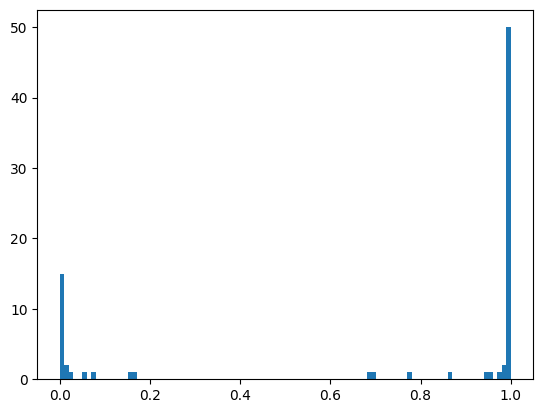

In [33]:
_ = plt.hist(model.predict_proba(X_test_scaled)[:,0], 100)

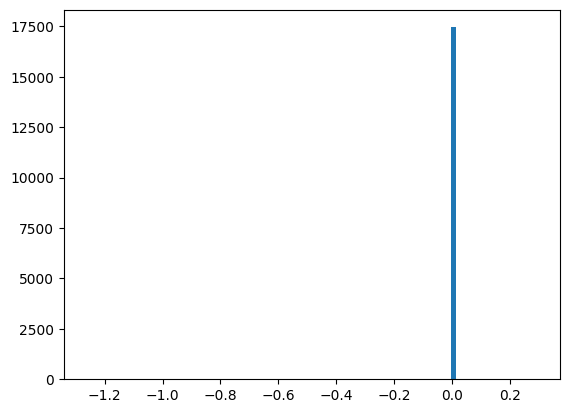

In [34]:
_ = plt.hist(model.coef_[0], 100)

In [35]:
sum(model.coef_[0] != 0)

312

In [36]:
indices = np.argsort(model.coef_[0])[::-1]

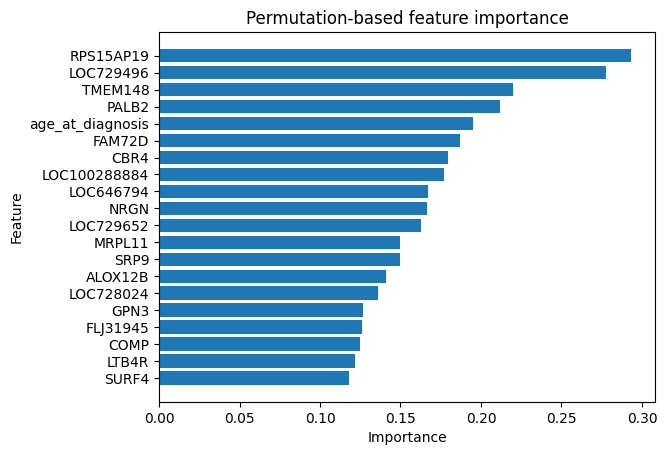

In [37]:
plt.barh(X_train_scaled.columns[indices][range(20)][::-1], model.coef_[0][indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

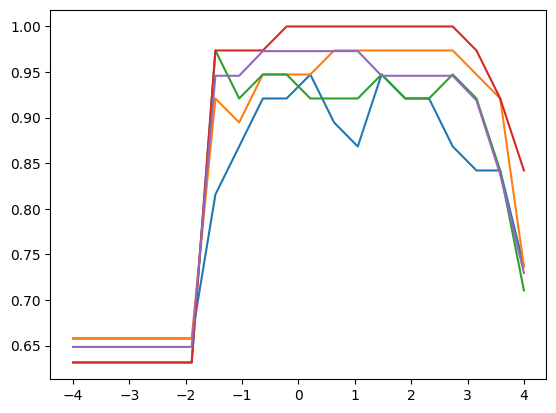

In [38]:
plt.plot(np.log10(model.Cs_), model.scores_[1].T)
plt.show()

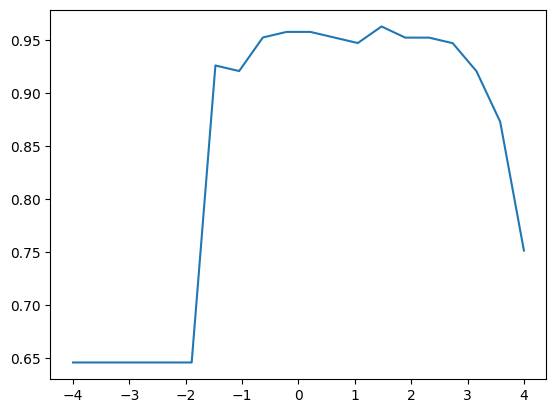

In [39]:
plt.plot(np.log10(model.Cs_), np.mean(model.scores_[1].T, axis = 1))
plt.show()

# Ranodm forest

In [40]:
from sklearn.ensemble import RandomForestClassifier


In [41]:
X_train = pd.concat([X_train, meta_train], axis=1)
X_test = pd.concat([X_test, meta_test], axis=1)

In [42]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=1234, class_weight="balanced")
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test.loc[:, X_train.columns])

In [43]:
accuracy = accuracy_score(y_test, y_pred)

In [44]:
accuracy

0.9876543209876543

In [45]:
pd.crosstab(y_pred, y_test)

class_label,0,1
row_0,,
0,58,1
1,0,22


In [46]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].class_label)

class_label,0.0,1.0
high_risk,,
0.0,58,5
1.0,0,18


In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      0.96      0.98        23

    accuracy                           0.99        81
   macro avg       0.99      0.98      0.98        81
weighted avg       0.99      0.99      0.99        81



In [48]:
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

In [49]:
# Print the feature ranking
print("Feature ranking:")
for f in range(20):
    print("%d. %s: feature %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. BAZ2B: feature 1206 (0.008116)
2. CAMTA1: feature 1570 (0.007058)
3. MINK1: feature 9693 (0.006922)
4. PRMT5: feature 12130 (0.006727)
5. high_risk: feature 17709 (0.006237)
6. SLC25A5: feature 14322 (0.005873)
7. FENL1: feature 4576 (0.005734)
8. POLE3: feature 11818 (0.005674)
9. inss_stage_4: feature 17713 (0.005626)
10. EXOSC9: feature 4053 (0.005370)
11. WSB1: feature 16942 (0.005182)
12. TOM1L2: feature 15967 (0.005104)
13. CNIH4: feature 2471 (0.004870)
14. PIRT: feature 11584 (0.004769)
15. HNRNPC: feature 6019 (0.004759)
16. NUP37: feature 10818 (0.004724)
17. PRKACB: feature 12095 (0.004667)
18. PGM2L1: feature 11450 (0.004505)
19. TRIAP1: feature 16089 (0.004481)
20. POLA1: feature 11809 (0.004400)


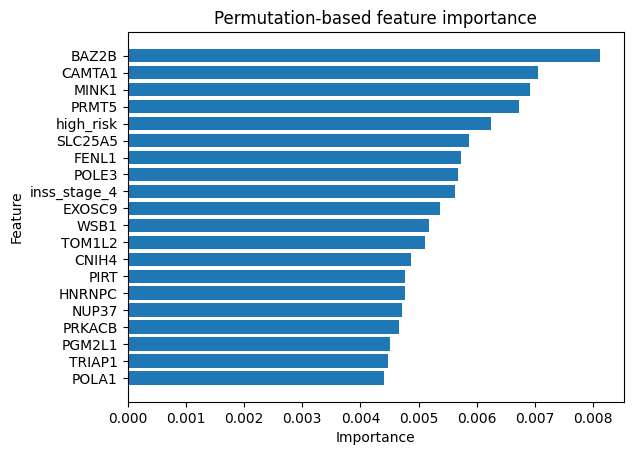

In [50]:
plt.barh(X_train.columns[indices][range(20)][::-1], importances[indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

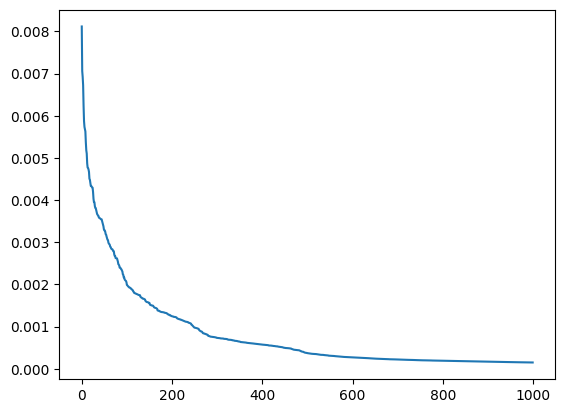

In [51]:
plt.plot(importances[indices][range(1000)])


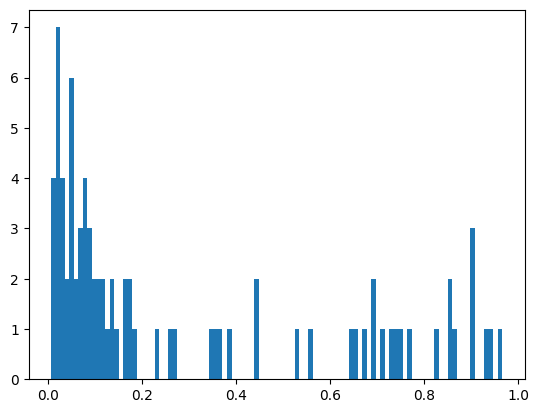

In [52]:
plt.hist(rf_classifier.predict_proba(X_test.loc[:, X_train.columns])[:,1], bins = 100)
plt.show()

In [53]:
meta_test

,Sex,age_at_diagnosis,mycn_status,high_risk,inss_stage_1,inss_stage_2,inss_stage_3,inss_stage_4,inss_stage_4S
sampleId,,,,,,,,,
SEQC_NB160,1.0,-0.347502,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SEQC_NB299,1.0,-0.426543,0.0,0.0,0.0,0.0,0.0,0.0,1.0
SEQC_NB314,1.0,-0.483486,1.0,1.0,0.0,0.0,0.0,1.0,0.0
SEQC_NB011,1.0,-0.298208,0.0,0.0,0.0,1.0,0.0,0.0,0.0
SEQC_NB296,1.0,-0.591422,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
SEQC_NB318,0.0,-0.395096,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SEQC_NB080,0.0,0.199831,1.0,1.0,0.0,0.0,1.0,0.0,0.0
SEQC_NB153,0.0,1.084573,0.0,0.0,1.0,0.0,0.0,0.0,0.0
